In [ ]:
!pip3 install asrtoolkit --user
!pip3 install fuzzywuzzy --user
!pip3 install python-Levenshtein --user
!pip3 install nltk

import asrtoolkit
from fuzzywuzzy import fuzz
import io
import os
from datetime import datetime
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats
from nltk.metrics import distance
import string

In [125]:
filenames = list(Path('predictions').glob('*.csv'))

results = pd.DataFrame()

models = list()

for idx, filename in enumerate(filenames):
    new_results = pd.read_csv(filename)
    model_label = Path(filename).stem.split('-')[0]
    ground_truth_label = f'{model_label}-ground_truth'
    new_results = new_results.rename(columns={'label': ground_truth_label, 
                            'prediction': model_label})
    del new_results['Unnamed: 0']
    models.append((ground_truth_label, model_label))
    new_results[ground_truth_label] = new_results.apply(lambda r: str(r[ground_truth_label]), axis=1)
    new_results[model_label] = new_results.apply(lambda r: str(r[model_label]), axis=1)
    results = pd.concat([results, new_results], axis = 1)

results

,run_55_train-ground_truth,run_55_train,run_41_train-ground_truth,run_41_train,run_55_all-ground_truth,run_55_all,run_41_all-ground_truth,run_41_all
0,A,"""",A,"""""",A,A,A,A
1,more,more,more,more,more,more,more,more
2,a,a,a,a,a,a,a,a
3,Foot,Toot,Foot,Foot,Foot,Foot,Foot,Foot
4,and,and,and,and,and,and,and,and
...,...,...,...,...,...,...,...,...
10826,In,"""""",In,(,In,In,In,In
10827,beside,borde,beside,bssrde,beside,beside,beside,beside
10828,in,in,in,in,in,in,in,in
10829,',"""",',"""",',"""",',""""


In [126]:
models

[('run_55_train-ground_truth', 'run_55_train'),
 ('run_41_train-ground_truth', 'run_41_train'),
 ('run_55_all-ground_truth', 'run_55_all'),
 ('run_41_all-ground_truth', 'run_41_all')]

In [127]:
NUM_STATS = 6
NUM_SUB_STATS = 5
a = ['matchratio'] * NUM_SUB_STATS + ['CER'] * NUM_SUB_STATS + ['matchratio_insensitive'] * NUM_SUB_STATS + ['CER_insensitive'] * NUM_SUB_STATS + ['matchratio_nopunc'] * NUM_SUB_STATS + ['CER_nopunc'] * NUM_SUB_STATS
b = ['mean', 'min', 'max', 'stdev', 'median'] * NUM_STATS
headers = pd.MultiIndex.from_arrays([a,b], names=('stat', 'substats'))
summary_results = pd.DataFrame(columns=headers)

def apply_stat(model_label: str, query_label: str, summary_stat_label: str, stat_function):
    results[query_label] = subset.apply(stat_function, axis=1)
    summary_results.loc[model_label, (summary_stat_label, 'mean')] = results[query_label].mean()
    summary_results.loc[model_label, (summary_stat_label, 'stdev')] = results[query_label].std()
    summary_results.loc[model_label, (summary_stat_label, 'min')] = results[query_label].min()
    summary_results.loc[model_label, (summary_stat_label, 'median')] = results[query_label].median()
    summary_results.loc[model_label, (summary_stat_label, 'max')] = results[query_label].max()
    subset[query_label] = results[query_label]
    
for ground_truth_label, model_label in models:
    subset = results[[ground_truth_label, model_label]].dropna()
    
    apply_stat(model_label, f'{model_label} CER', 'CER', lambda r: asrtoolkit.cer(str(r[ground_truth_label]), str(r[model_label])))
    apply_stat(model_label, f'{model_label} match ratio', 'matchratio', lambda r: fuzz.ratio(str(r[ground_truth_label]), str(r[model_label])))
    results[f'{model_label}-edit_distance'] = subset.apply(lambda r: distance.edit_distance(str(r[ground_truth_label]), str(r[model_label])), axis=1)
    
    subset[f'{ground_truth_label}-lower'] = subset[ground_truth_label].map(str.lower)
    subset[f'{model_label}-lower'] = subset[model_label].map(str.lower)
    apply_stat(model_label, f'{model_label} CER insensitive', 'CER_insensitive', lambda r: asrtoolkit.cer(str(r[f'{ground_truth_label}-lower']), str(r[f'{model_label}-lower'])))
    apply_stat(model_label, f'{model_label} match ratio insensitive', 'matchratio_insensitive', lambda r: fuzz.ratio(str(r[f'{ground_truth_label}-lower']), str(r[f'{model_label}-lower'])))
    
    subset[f'{ground_truth_label}-nopunc'] = subset[ground_truth_label].map(lambda s: s.translate(str.maketrans('', '', string.punctuation)))
    subset = subset.loc[subset[f'{ground_truth_label}-nopunc'].str.len() > 0]
    subset[f'{model_label}-nopunc'] = subset[model_label].map(lambda s: s.translate(str.maketrans('', '', string.punctuation)))
    subset = subset.loc[subset[f'{model_label}-nopunc'].str.len() > 0]
    apply_stat(model_label, f'{model_label} CER no punc', 'CER_nopunc', lambda r: asrtoolkit.cer(str(r[f'{ground_truth_label}-nopunc']), str(r[f'{model_label}-nopunc'])))
    apply_stat(model_label, f'{model_label} match ratio no punc', 'matchratio_nopunc',  lambda r: fuzz.ratio(str(r[f'{ground_truth_label}-lower']), str(r[f'{model_label}-lower'])))
    
    exact = results.apply(lambda r: 1 if int(r[f'{model_label}-edit_distance']) == 0 else 0, axis=1).sum()
    oboe = results.apply(lambda r: 1 if int(r[f'{model_label}-edit_distance']) == 1 else 0, axis=1).sum()
    summary_results.loc[model_label, 'exact_matches'] = pd.to_numeric(exact, downcast='integer')
    summary_results.loc[model_label, 'oboe_matches'] = pd.to_numeric(oboe, downcast='integer')
    
    err_range = stats.norm.interval(alpha=0.95, 
                                  loc=np.mean(results[f'{model_label} CER'].dropna()), 
                                  scale=stats.sem(results[f'{model_label} CER'].dropna()))
    summary_results.loc[model_label, 'cer_95_error_min'] = err_range[0]
    summary_results.loc[model_label, 'cer_95_error_max'] = err_range[1]

In [129]:
print(summary_results[[('CER', 'mean'), ('CER_insensitive', 'mean'), ('CER_nopunc', 'mean'), 
                       ('matchratio', 'mean'), ('matchratio_insensitive', 'mean'), ('matchratio_nopunc', 'mean')]])
print(summary_results[['exact_matches', 'oboe_matches', 'cer_95_error_min', 'cer_95_error_max']])

stat                CER CER_insensitive CER_nopunc matchratio  \
substats           mean            mean       mean       mean   
run_55_train  14.060104       14.023242  12.233352  82.751454   
run_41_train  12.637878       12.583424  10.976181  83.380944   
run_55_all     2.249663        2.233371   1.622164  92.227495   
run_41_all     1.818202         1.80787   1.269162   92.38953   

stat         matchratio_insensitive matchratio_nopunc  
substats                       mean              mean  
run_55_train              83.722371         90.787441  
run_41_train              84.322962         91.348525  
run_55_all                92.316499         98.815974  
run_41_all                92.501893         99.035984  
stat         exact_matches oboe_matches cer_95_error_min cer_95_error_max
substats                                                                 
run_55_train        6888.0       2109.0        13.365721        14.754488
run_41_train        6955.0       2192.0        12.0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


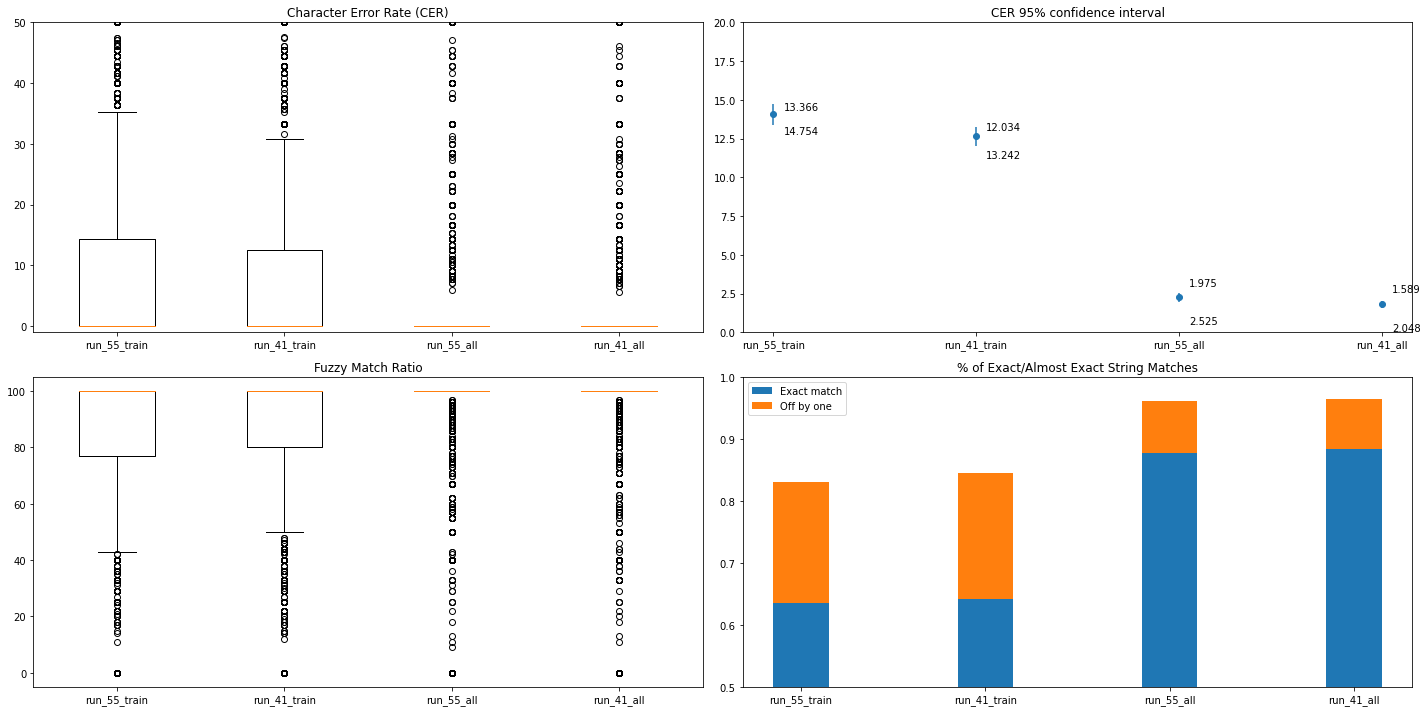

In [130]:
def plot_cer(graph):
    graph.set_title('Character Error Rate (CER)')
    graph.set_xticklabels([label[1] for label in models])
    graph.set_ylim([-1, 50])  # TODO -10, 400  ***********************************************************************************
    subset = results[[f'{label[1]} CER' for label in models]].T
    subset = np.asarray([model[1].dropna() for model in subset.iterrows()], dtype=object).T
    graph = graph.boxplot(subset)


def plot_cer_confidence_interval(graph):
    min = summary_results['cer_95_error_min']
    min = min.apply(lambda v: v if v >= 0 else 0)
    max = summary_results['cer_95_error_max']
    max = max.apply(lambda v: v if v <= 100 else 100)
    error_min = [summary_results.loc[label[1], ('CER', 'mean')] - min[label[1]] for label in models]
    error_max = [max[label[1]] - summary_results.loc[label[1], ('CER', 'mean')] for label in models]
    graph.set_title('CER 95% confidence interval')
    graph.set_xticklabels([label[1] for label in models])
    graph.set_ylim(top=20)  # TODO 100 ***********************************************************************************
    graph.errorbar([label[1] for label in models], summary_results[('CER', 'mean')], yerr=[error_min, error_max], fmt='o')
    for i in range(len(models)):
        graph.text(i + 0.05, max[i] - 2, f'{max[i]:.3f}')
        graph.text(i + 0.05, min[i] + 1, f'{min[i]:.3f}')


def plot_fuzzy_match(graph):
    graph.set_title('Fuzzy Match Ratio')
    graph.set_xticklabels([label[1] for label in models])
    subset = results[[f'{label[1]} match ratio' for label in models]].T
    subset = np.asarray([model[1].dropna() for model in subset.iterrows()], dtype=object).T
    graph = graph.boxplot(subset)


def plot_close_matches(graph):  # todo
    graph.set_title('% of Exact/Almost Exact String Matches')
    exact_matches = [match/results.shape[0] for match in summary_results['exact_matches']]
    obo_matches = [match/results.shape[0] for match in summary_results['oboe_matches']]
    ex = graph.bar([label[1] for label in models], exact_matches, 
                   width=0.3, label='Exact match')
    obo = graph.bar([label[1] for label in models], obo_matches, 
                    width=0.3, bottom=exact_matches, label='Off by one')
    graph.set_ybound(0.5, 1)
    graph.legend()


fig, ((graph1, graph2), (graph3, graph4)) = plt.subplots(2, 2, figsize=(20, 10))
# fig, graph1 = plt.subplots(1, 1, figsize=(10, 7))  # For saving individual charts

plot_cer(graph1)
plot_cer_confidence_interval(graph2)
plot_fuzzy_match(graph3)
plot_close_matches(graph4)
fig.tight_layout()

# Save these results to the filesystem

In [131]:
results_folder = 'results'
if not os.path.exists(results_folder):
    os.makedirs(results_folder)
timestamp = datetime.now().strftime('%Y_%m_%d-%H_%M_%S')
summary_results.to_csv(Path(results_folder, f'summary-{timestamp}.csv'))
fig.savefig(Path(results_folder, f'summary-{timestamp}.png'))